<a href="https://colab.research.google.com/github/jnoms/ESCC_microbiome/blob/main/collab/Figure2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading data

In [ ]:
# Data
! wget https://zenodo.org/record/4750577/files/2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1
! mv  2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1 package.zip
! unzip package.zip
! mv 2021-05-11_ESCC_MICROBIOME_UPLOAD/data data
! mv 2021-05-11_ESCC_MICROBIOME_UPLOAD/functions.r functions.r

# Setting up environment and loading R packages

In [10]:
%load_ext rpy2.ipython

In [11]:
%%R
install.packages("pheatmap")
install.packages("reshape2")
install.packages("hash")
install.packages("patchwork")
install.packages("vegan")
install.packages("ggplotify")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/pheatmap_1.0.12.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 15071 bytes (14 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

In [12]:
%%R
library(tidyverse)
library(pheatmap)
library(reshape2)
library(svglite)
library(hash)
library(patchwork)
library(magrittr)


# Bray curtis
library(vegan)

# Plotting 
library(scales) #allows use of "comma" to replace i.e. 1e6 with 1,000,000 during plotting


# My functions
source("functions.r")

library(RColorBrewer) #for specifying pheatmap colorscheme

library(ggplotify) # Convert pheatmaps to ggplot objects using as.ggplot

select <- dplyr::select # for some reason, select is preemted... so put it back to the tidyverse select.

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: hash-2.2.6.1 provided by Decision Patterns


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattic

# Constants and load/format data in R

In [13]:
%%R
# Constants
info_cols <- c("tax_id","taxonomy","type","kingdom","reference_length","mean","median","max")
cohort_order <- c("TCGA COAD", "TCGA ESCC", "Golestan, Iran", "Shanxi, China", "ESCCAPE Kenya", "ESCCAPE Tanzania", "MUHAS Tanzania", "MUHAS Tanzania (RNA)", "UNC Project - Malawi (RNA)")

In [14]:
%%R
# Import MUHAS Tz
rna <- read_tsv("data/tanz_RNAseq_score.txt")
wgs <- read_tsv("data/tanz_WGS_score.txt")
metadata <- read_csv("data/tanzania-bams-2019-02-19.csv")

# Because mycobacterium reads are actually human reads that are mismapped, remove them all
rna <- rna %>%
  filter(!grepl("Mycobacterium", taxonomy))
wgs <- wgs %>%
  filter(!grepl("Mycobacterium", taxonomy))

# Format input files
colnames(rna) <- str_replace_all(colnames(rna), ".pathseq.tsv","")
colnames(wgs) <- str_replace_all(colnames(wgs), ".pathseq.tsv","")

# Get list of non-sample, non-name columns
info_cols <- colnames(rna)[1:9]
info_cols <- info_cols[info_cols!='name']

# Split wgs to saliva vs tumor

# -- Make key to convert ID to type
ID_to_type <- hash(metadata$`sample uuid`, metadata$`T/n`)

# -- Get list of samples in each category
tumor_list <- colnames(wgs)[10:length(wgs)][hash_lookup(ID_to_type, colnames(wgs)[10:length(wgs)]) == "Tumor"]
saliva_list <- colnames(wgs)[10:length(wgs)][hash_lookup(ID_to_type, colnames(wgs)[10:length(wgs)]) == "Normal"]

# -- Make a dataframe for each category
wgs_tumor <- wgs[c(colnames(wgs)[1:9], tumor_list)]
wgs_saliva <- wgs[c(colnames(wgs)[1:9], saliva_list)]

# Make key to convert ID to name
ID_to_name <- hash(metadata$`sample uuid`, metadata$sample_name)

# Convert the column names in rna and wgs dataframes
colnames(rna)[10:length(rna)] <- hash_lookup(ID_to_name, colnames(rna)[10:length(rna)])
colnames(wgs_tumor)[10:length(wgs_tumor)] <- hash_lookup(ID_to_name, colnames(wgs_tumor)[10:length(wgs_tumor)])
colnames(wgs_saliva)[10:length(wgs_saliva)] <- hash_lookup(ID_to_name, colnames(wgs_saliva)[10:length(wgs_saliva)])

# Need to remove samples that lack metadata because they failed QC - i.e. are not 
# the correct cancer type, etc.
rna <- rna[colnames(rna)[!is.na(colnames(rna))]]


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_name = col_character(),
  `sample uuid` = col_character(),
  file_size = col_double(),
  md5 = col_character(),
  read_count = col_double(),
  map_percent = col_double(),
  genome_cov = col_double(),
  template_length = col_double(),
  analyte = col_character(),
  `T/n` = col_character()
)



In [15]:
%%R
# Import MUHAS tz metrics
# import the files
wgs_metrics <- read_delim("data/tanz_wgs.metrics.txt", delim="\t")
rna_metrics <- read_delim("data/tanz_rnaseq.metrics.txt", delim="\t")

# Split the wgs_metrics to tumor and saliva
# Will use the existing tumor_list and saliva_list from above
colnames(wgs_metrics) <- str_replace_all(colnames(wgs_metrics), ".pathseq.filter_metrics", "")
wgs_metrics_tumor <- wgs_metrics[c("X1", tumor_list)]
wgs_metrics_saliva <- wgs_metrics[c("X1", saliva_list)]

# Format the metrics
wgs_metrics_tumor <- format_metrics(wgs_metrics_tumor, ID_to_name)
wgs_metrics_saliva <- format_metrics(wgs_metrics_saliva, ID_to_name)
rna_metrics <- format_metrics(rna_metrics, ID_to_name)


# For the WGS data, I processed the host-subtracted reads through PathSeq. 
# This means I need to go back and, for the HOST_READS_FILTERED, add those
# counts
wgs_initial_counts <- read_delim("data/tz_WGS_COUNTS_of_reads_subtracted_before_pathseq.csv", delim=",", col_names=c("name", "count"))
wgs_initial_counts$name <- str_replace_all(wgs_initial_counts$name, ".bam", "")

# Make hash of initial human_counts
wgs_initial_counts_map <- hash(wgs_initial_counts$name, wgs_initial_counts$count)

# Will add the counts. Because the company may not have given all original BAMs, exlude
# those samples that don't have original counts...
wgs_metrics_tumor <- wgs_metrics_tumor %>%
  mutate(HOST_READS_FILTERED = as.numeric(as.character(HOST_READS_FILTERED))) %>%
  filter(name %in% wgs_initial_counts$name) %>%
  mutate(HOST_READS_FILTERED = HOST_READS_FILTERED + hash_lookup(wgs_initial_counts_map, name))
  
wgs_metrics_saliva <- wgs_metrics_saliva %>%
  mutate(HOST_READS_FILTERED = as.numeric(as.character(HOST_READS_FILTERED))) %>%
  filter(name %in% wgs_initial_counts$name) %>%
  mutate(HOST_READS_FILTERED = HOST_READS_FILTERED + hash_lookup(wgs_initial_counts_map, name))

# Convert sample names to patient IDs
wgs_metrics_tumor$name <- hash_lookup(ID_to_name, wgs_metrics_tumor$name)
wgs_metrics_saliva$name <- hash_lookup(ID_to_name, wgs_metrics_saliva$name)
rna_metrics$name <- hash_lookup(ID_to_name, rna_metrics$name)


# For the RNA metrics, need to remove samples that don't have a name (meaning they're not in the key, probably because they are ruled out samples because they're not ESCC)
rna_metrics <- rna_metrics %>%
  filter(!is.na(name))


# Make hashes for get # human reads
tz_wgs_tumor_hu_hashmap <- hash(wgs_metrics_tumor$name, make_factor_numeric(wgs_metrics_tumor$HOST_READS_FILTERED))
tz_wgs_saliva_hu_hashmap <- hash(wgs_metrics_saliva$name, make_factor_numeric(wgs_metrics_saliva$HOST_READS_FILTERED))
tz_rna_hu_hashmap <- hash(rna_metrics$name, make_factor_numeric(rna_metrics$HOST_READS_FILTERED))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  count = col_double()
)



In [16]:
%%R
# Import Malawi
malawi <- read_delim("data/malawi_rnaseq_partial.score.txt", delim="\t")

# Format colnames
colnames(malawi) <- str_replace_all(colnames(malawi), "_tumor.pathseq.tsv", "")
colnames(malawi) <- str_replace_all(colnames(malawi), "_normal.pathseq.tsv", "") # NOTE - none of these RNA samples are actually normal! This was me miss-labeling things. There are NO normal RNAseq samples.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.



R[write to console]: Warning:
R[write to console]:  21120 parsing failures.
row col   expected     actual                                   file
  1  -- 36 columns 37 columns 'data/malawi_rnaseq_partial.score.txt'
  2  -- 36 columns 37 columns 'data/malawi_rnaseq_partial.score.txt'
  3  -- 36 columns 37 columns 'data/malawi_rnaseq_partial.score.txt'
  4  -- 36 columns 37 columns 'data/malawi_rnaseq_partial.score.txt'
  5  -- 36 columns 37 columns 'data/malawi_rnaseq_partial.score.txt'
... ... .......... .......... ......................................
See problems(...) for more details.




In [17]:
%%R
# Import Malawi metrics
malawi_metrics <- read_delim("data/malawi_rnaseq.metrics.txt", delim="\t")

# Format colnames
# NOTE - none of these RNA samples are actually normal! This was me miss-labeling things. There are NO normal RNAseq samples.
colnames(malawi_metrics) <- str_replace_all(colnames(malawi_metrics), "_tumor.pathseq.filter_metrics", "") %>%
  str_replace_all("_normal.pathseq.filter_metrics", "")

malawi_metrics <- format_metrics(malawi_metrics)

#Make hash
malawi_hu_hashmap <- hash(malawi_metrics$name, make_factor_numeric(malawi_metrics$HOST_READS_FILTERED))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.



In [18]:
%%R
# Import mutographs
mutographs <- read_delim("data/mutographs/mutographs1_5.score.txt", delim="\t")
mutographs_key <- read_delim("data/mutographs/mutographs_key.txt", delim="\t")

# Remove the obsolete blood samples
blood_samples <- colnames(mutographs)[grep("blood", colnames(mutographs))]
mutographs <- mutographs %>%
  select(-blood_samples)

# Format the column names
colnames(mutographs) <- basename(colnames(mutographs)) %>%
  str_replace_all("_tumor", "") %>%
  str_replace_all(".pathseq.txt", "")

# Patients 42 and 43 are split, so need to re-label the second samples and then consolidate them
#--------------------------------------------------------------------------------------------------#
colnames(mutographs)[colnames(mutographs) == "42"][2] <- "42.1"
colnames(mutographs)[colnames(mutographs) == "43"][2] <- "43.1"


# Make character for better handling
colnames(mutographs) <- as.character(colnames(mutographs))


vals_42 <- mutographs %>%
  pull("42")
vals_42.1 <- mutographs %>%
  pull("42.1")
vals_42_agg <- vals_42 + vals_42.1
mutographs$`42` <- vals_42_agg
mutographs$`42.1` <- NULL

vals_43 <- mutographs %>%
  pull("43")
vals_43.1 <- mutographs %>%
  pull("43.1")
vals_43_agg <- vals_43 + vals_43.1
mutographs$`43` <- vals_43_agg
mutographs$`43.1` <- NULL

# Turn sample numbers back to numeric...
colnames(mutographs)[7:ncol(mutographs)] <- as.numeric(colnames(mutographs)[7:ncol(mutographs)])
#--------------------------------------------------------------------------------------------------#


# Make a hashmap to convert case_identifier to country
mutographs_hashmap <- hash(as.factor(mutographs_key$case_identifier), mutographs_key$country)
  


# Make copies of mutographs that are split by cohort - Tz, Kenya, China, Iran
muto_tz_list <- colnames(mutographs)[7:length(mutographs)][hash_lookup(mutographs_hashmap, colnames(mutographs)[7:length(mutographs)]) == "Tanzania"]
muto_china_list <- colnames(mutographs)[7:length(mutographs)][hash_lookup(mutographs_hashmap, colnames(mutographs)[7:length(mutographs)]) == "China"]
muto_kenya_list <-  colnames(mutographs)[7:length(mutographs)][hash_lookup(mutographs_hashmap, colnames(mutographs)[7:length(mutographs)]) == "Kenya"]
muto_iran_list <-  colnames(mutographs)[7:length(mutographs)][hash_lookup(mutographs_hashmap, colnames(mutographs)[7:length(mutographs)]) == "Iran"]

mutographs_tz <- mutographs %>%
  select(colnames(mutographs)[1:6], muto_tz_list)
mutographs_china <- mutographs %>%
  select(colnames(mutographs)[1:6], muto_china_list)
mutographs_kenya <- mutographs %>%
  select(colnames(mutographs)[1:6], muto_kenya_list)
mutographs_iran <- mutographs %>%
  select(colnames(mutographs)[1:6], muto_iran_list)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.

|===================================================================| 100% 18 MB


R[write to console]: Warning:
R[write to console]:  15335 parsing failures.
row col    expected      actual                                      file
  1  -- 224 columns 225 columns 'data/mutographs/mutographs1_5.score.txt'
  2  -- 224 columns 225 columns 'data/mutographs/mutographs1_5.score.txt'
  3  -- 224 columns 225 columns 'data/mutographs/mutographs1_5.score.txt'
  4  -- 224 columns 225 columns 'data/mutographs/mutographs1_5.score.txt'
  5  -- 224 columns 225 columns 'data/mutographs/mutographs1_5.score.txt'
... ... ........... ........... .........................................
See problems(...) for more details.





── Column specification ────────────────────────────────────────────────────────
cols(
  case_identifier = col_double(),
  country = col_character(),
  batch = col_double()
)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(blood_samples)` instead of `blood_samples` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(muto_tz_list)` instead of `muto_tz_list` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(muto_china_list)` instead of `muto_china_list` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is

In [19]:
%%R
# Import Mutographs metrics
mutographs_metrics <- read_delim("data/mutographs/mutographs1_5.metrics.txt", delim="\t")

# Remove the obsolete blood samples
blood_samples <- colnames(mutographs_metrics)[grep("blood", colnames(mutographs_metrics))]
mutographs_metrics <- mutographs_metrics %>%
  select(-blood_samples)

# Format the column names
colnames(mutographs_metrics) <- basename(colnames(mutographs_metrics)) %>%
  str_replace_all("_tumor", "") %>%
  str_replace_all(".filter_metrics.txt", "")



# Patients 42 and 43 are split, so need to re-label the second samples and then consolidate them
#--------------------------------------------------------------------------------------------------#
colnames(mutographs_metrics)[colnames(mutographs_metrics) == "42"][2] <- "42.1"
colnames(mutographs_metrics)[colnames(mutographs_metrics) == "43"][2] <- "43.1"

vals_42 <- mutographs_metrics %>%
  pull("42")
vals_42.1 <- mutographs_metrics %>%
  pull("42.1")
vals_42_agg <- vals_42 + vals_42.1
mutographs_metrics$`42` <- vals_42_agg
mutographs_metrics$`42.1` <- NULL

vals_43 <- mutographs_metrics %>%
  pull("43")
vals_43.1 <- mutographs_metrics %>%
  pull("43.1")
vals_43_agg <- vals_43 + vals_43.1
mutographs_metrics$`43` <- vals_43_agg
mutographs_metrics$`43.1` <- NULL
#--------------------------------------------------------------------------------------------------#

# Format them
mutographs_metrics <- format_metrics(mutographs_metrics)



# Import the counts of the human-mapped reads that were not processed through PathSeq
mutographs_hu_read_counts <- read_delim("data/mutographs/mutographs_human_mapped_counts.txt", delim="\t")
mutographs_hu_read_counts$name <- as.character(mutographs_hu_read_counts$name)
mutographs_hu_read_counts$count <- as.numeric(mutographs_hu_read_counts$count)
mutographs_hu_read_counts_hashmap <- hash(mutographs_hu_read_counts$name, mutographs_hu_read_counts$count)

# Add counts to the pathseq metrics file
mutographs_metrics <- mutographs_metrics %>%
  mutate(HOST_READS_FILTERED = as.numeric(HOST_READS_FILTERED) + hash_lookup(mutographs_hu_read_counts_hashmap,name))

mutographs_hu_hashmap <- hash(mutographs_metrics$name, make_factor_numeric(mutographs_metrics$HOST_READS_FILTERED))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_double(),
  count = col_character()
)



In [20]:
%%R
# Import TCGA ESCC
#------------------------------------------------------------------------------------------#
# Input data and format data
#------------------------------------------------------------------------------------------#
tcga_wgs <- read_tsv("data/tcga_escc_a_data/tcga_esca_wgs_score.txt")
tcga_clin_info <- read_tsv("data/tcga_escc_a_data/TCGA_ESCA-C_clinical_data.tsv")

# Because mycobacterium reads are actually human reads that are mismapped, remove them all
tcga_wgs <- tcga_wgs %>%
  filter(!grepl("Mycobacterium", taxonomy))

# Remove normal samples from input dataframes
tcga_wgs <- tcga_wgs %>%
  select(-contains("NT")) %>%
  select(-contains("TM"))

# Format colnames to remove .pathseq.tsv and such
colnames(tcga_wgs) <- str_replace_all(colnames(tcga_wgs), "-TP.pathseq.tsv", "")

# Format clinical names
tcga_clin_info$submitter_id <- str_replace_all(tcga_clin_info$submitter_id, "TCGA", "ESCA")

# make hashmap to convert name to diagnosis
tcga_id_to_type <- hash(tcga_clin_info$submitter_id, tcga_clin_info$primary_diagnosis)

# Select only squamous cancers...
wgs_types <- hash_lookup(tcga_id_to_type, colnames(tcga_wgs)[7:length(tcga_wgs)])
wgs_cols_to_keep <- c(colnames(tcga_wgs)[1:6], colnames(tcga_wgs)[7:length(tcga_wgs)][grepl("Squamous", wgs_types)])
tcga_wgs <- tcga_wgs %>%
  select(wgs_cols_to_keep)

# Also bring in country of origin information
tcga_clinical_cbio <- read_delim("data/cBioportal_TCGA_ESCAcohort_clinical/esca_tcga_clinical_data.tsv", delim="\t")

# Make annotation and add to dataframe
tcga_ID_to_country <- hash(str_replace_all(tcga_clinical_cbio$`Patient ID`, "TCGA", "ESCA"), tcga_clinical_cbio$`Tumor sample procurement country`)

# For TCGA, I will just split into separate countries first thing.




tcga_RU <- tcga_wgs %>%
  select(colnames(tcga_wgs)[1:6],
         colnames(tcga_wgs)[7:length(tcga_wgs)][hash_lookup(tcga_ID_to_country, colnames(tcga_wgs)[7:length(tcga_wgs)]) == "Russia"])

tcga_UKR <- tcga_wgs %>%
  select(colnames(tcga_wgs)[1:6],
         colnames(tcga_wgs)[7:length(tcga_wgs)][hash_lookup(tcga_ID_to_country, colnames(tcga_wgs)[7:length(tcga_wgs)]) == "Ukraine"])

tcga_USA <- tcga_wgs %>%
  select(colnames(tcga_wgs)[1:6],
         colnames(tcga_wgs)[7:length(tcga_wgs)][hash_lookup(tcga_ID_to_country, colnames(tcga_wgs)[7:length(tcga_wgs)]) == "United States"])

tcga_VT <- tcga_wgs %>%
  select(colnames(tcga_wgs)[1:6],
         colnames(tcga_wgs)[7:length(tcga_wgs)][hash_lookup(tcga_ID_to_country, colnames(tcga_wgs)[7:length(tcga_wgs)]) == "Vietnam"])


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.



R[write to console]: Warning:
R[write to console]:  17058 parsing failures.
row col   expected     actual                                            file
  1  -- 57 columns 58 columns 'data/tcga_escc_a_data/tcga_esca_wgs_score.txt'
  2  -- 57 columns 58 columns 'data/tcga_escc_a_data/tcga_esca_wgs_score.txt'
  3  -- 57 columns 58 columns 'data/tcga_escc_a_data/tcga_esca_wgs_score.txt'
  4  -- 57 columns 58 columns 'data/tcga_escc_a_data/tcga_esca_wgs_score.txt'
  5  -- 57 columns 58 columns 'data/tcga_escc_a_data/tcga_esca_wgs_score.txt'
... ... .......... .......... ...............................................
See problems(...) for more details.





── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  age_at_diagnosis = col_double(),
  days_to_birth = col_double()
)
ℹ Use `spec()` for the full column specifications.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(wgs_cols_to_keep)` instead of `wgs_cols_to_keep` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  `Diagnosis Age` = col_double(),
  `Alcohol Consumption Frequency` = col_double(),
  `Daily Alcohol` = col_double(),
  `Days to Sample Collection.` = col_double(),
  `Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value` = col_double(),
  days_to_patient_progression_free = col_logical(),
  `Days to Sample Procurement` = col_logical(),
  days_to_tumor_progress

In [21]:
%%R
# Import TCGA ESCC metrics
tcga_metrics <- read_delim("data/tcga_escc_a_data/tcga_esca_wgs.pathseq.metrics.txt", delim="\t")

# Format colnames
colnames(tcga_metrics) <- colnames(tcga_metrics) %>% 
  str_replace_all(".pathseq.filter_metrics", "") %>%
  str_replace_all("-TP", "")

tcga_metrics <- format_metrics(tcga_metrics)

#Make hash
tcga_hu_hashmap <- hash(tcga_metrics$name, make_factor_numeric(tcga_metrics$HOST_READS_FILTERED))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.



In [22]:
%%R
# Import TCGA COAD tumor for pos control
COAD_tumor <- read_tsv("data/tcga_coad/COAD_WGS/COAD_WGS.score.txt")
colnames(COAD_tumor) <- str_replace_all(colnames(COAD_tumor), ".unmapped.pathseq.txt", "")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.



R[write to console]: Warning:
R[write to console]:  18460 parsing failures.
row col   expected     actual                                         file
  1  -- 57 columns 58 columns 'data/tcga_coad/COAD_WGS/COAD_WGS.score.txt'
  2  -- 57 columns 58 columns 'data/tcga_coad/COAD_WGS/COAD_WGS.score.txt'
  3  -- 57 columns 58 columns 'data/tcga_coad/COAD_WGS/COAD_WGS.score.txt'
  4  -- 57 columns 58 columns 'data/tcga_coad/COAD_WGS/COAD_WGS.score.txt'
  5  -- 57 columns 58 columns 'data/tcga_coad/COAD_WGS/COAD_WGS.score.txt'
... ... .......... .......... ............................................
See problems(...) for more details.




In [23]:
%%R
# Import TCGA COAD tumor for pos control - METRICS
COAD_tumor_metrics <- read_delim("data/tcga_coad/COAD_WGS/COAD_WGS.metrics.txt", delim="\t")
colnames(COAD_tumor_metrics) <- str_replace_all(colnames(COAD_tumor_metrics), ".unmapped.filter_metrics.txt", "")
COAD_tumor_metrics <- format_metrics(COAD_tumor_metrics)



# Make a hash to add original counts
COAD_tumor_original_mapped_counts <- read_csv("data/tcga_coad/COAD_WGS/COAD_WGS_OG_MAPPED_COUNTS.csv", col_names = c("sample", "count"))
COAD_tumor_original_mapped_counts$sample <- str_replace_all(COAD_tumor_original_mapped_counts$sample, ".bam", "")
COAD_tumor_original_counts_hash <- hash(COAD_tumor_original_mapped_counts$sample, COAD_tumor_original_mapped_counts$count)

# Add OG counts 
COAD_tumor_metrics <- COAD_tumor_metrics %>%
  mutate(HOST_READS_FILTERED = make_factor_numeric(HOST_READS_FILTERED) + hash_lookup(COAD_tumor_original_counts_hash, name))

#Make hash
COAD_tumor_hashmap <- hash(COAD_tumor_metrics$name, make_factor_numeric(COAD_tumor_metrics$HOST_READS_FILTERED))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  count = col_double()
)



In [24]:
%%R
# Make copeis of the dataframes that are normalized to # human reads
# Tz Cohort
wgs_tumor_hu_norm <- normalize_to_human_reads(wgs_tumor, tz_wgs_tumor_hu_hashmap, number_of_nonname_columns = length(colnames(wgs)[colnames(wgs) %in% info_cols]))
rna_hu_norm <- normalize_to_human_reads(rna, tz_wgs_tumor_hu_hashmap, number_of_nonname_columns = length(colnames(rna)[colnames(rna) %in% info_cols]))

# Malawi cohort
malawi_hu_norm <- normalize_to_human_reads(malawi, malawi_hu_hashmap, number_of_nonname_columns = length(colnames(malawi)[colnames(malawi) %in% info_cols]))

# Mutographs - both the aggregated one and the split ones to keep options open
mutographs_hu_norm <- normalize_to_human_reads(mutographs, mutographs_hu_hashmap, number_of_nonname_columns = length(colnames(mutographs)[colnames(mutographs) %in% info_cols]))

mutographs_tz_hu_norm <- normalize_to_human_reads(mutographs_tz, mutographs_hu_hashmap, number_of_nonname_columns = length(colnames(mutographs_tz)[colnames(mutographs_tz) %in% info_cols]))
mutographs_china_hu_norm <- normalize_to_human_reads(mutographs_china, mutographs_hu_hashmap, number_of_nonname_columns = length(colnames(mutographs_china)[colnames(mutographs_china) %in% info_cols]))
mutographs_kenya_hu_norm <- normalize_to_human_reads(mutographs_kenya, mutographs_hu_hashmap, number_of_nonname_columns = length(colnames(mutographs_kenya)[colnames(mutographs_kenya) %in% info_cols]))
mutographs_iran_hu_norm <- normalize_to_human_reads(mutographs_iran, mutographs_hu_hashmap, number_of_nonname_columns = length(colnames(mutographs_iran)[colnames(mutographs_iran) %in% info_cols]))


# TCGA - also for both aggregated and split tables.
tcga_wgs_hu_norm <- normalize_to_human_reads(tcga_wgs, tcga_hu_hashmap, number_of_nonname_columns = length(colnames(tcga_wgs)[colnames(tcga_wgs) %in% info_cols]))

tcga_RU_hu_norm <- normalize_to_human_reads(tcga_RU, tcga_hu_hashmap, number_of_nonname_columns = length(colnames(tcga_RU)[colnames(tcga_RU) %in% info_cols]))
tcga_UKR_hu_norm <- normalize_to_human_reads(tcga_UKR, tcga_hu_hashmap, number_of_nonname_columns = length(colnames(tcga_UKR)[colnames(tcga_UKR) %in% info_cols]))
tcga_USA_hu_norm <- normalize_to_human_reads(tcga_USA, tcga_hu_hashmap, number_of_nonname_columns = length(colnames(tcga_USA)[colnames(tcga_USA) %in% info_cols]))
tcga_VT_hu_norm <- normalize_to_human_reads(tcga_VT, tcga_hu_hashmap, number_of_nonname_columns = length(colnames(tcga_VT)[colnames(tcga_VT) %in% info_cols]))

# For COAD tumor
COAD_tumor_hu_norm <- normalize_to_human_reads(COAD_tumor, COAD_tumor_hashmap, number_of_nonname_columns = length(colnames(COAD_tumor)[colnames(COAD_tumor) %in% info_cols]))

In [25]:
%%R
# Making aggregated copies for each dataframe for faceted plots
# First minimize the columns present in each tibble - only keep tax_id, name, kingdom for the info columns. 
cols_to_drop <- c("reference_length", "mean", "median", "max")

wgs_tumor <- wgs_tumor %>%
  select(-cols_to_drop)
rna <- rna %>%
  select(-cols_to_drop)
malawi <- malawi %>%
  select(-cols_to_drop[1])
tcga_wgs <- tcga_wgs %>%
  select(-cols_to_drop[1])
mutographs <- mutographs %>%
  select(-cols_to_drop[1])
COAD_tumor <- COAD_tumor %>%
  select(-cols_to_drop[1])

wgs_tumor_hu_norm <- wgs_tumor_hu_norm %>%
  select(-cols_to_drop)
rna_hu_norm <- rna_hu_norm %>%
  select(-cols_to_drop)
malawi_hu_norm <- malawi_hu_norm %>%
  select(-cols_to_drop[1])
tcga_wgs_hu_norm <- tcga_wgs_hu_norm %>%
  select(-cols_to_drop[1])
mutographs_hu_norm <- mutographs_hu_norm %>%
  select(-cols_to_drop[1])
COAD_tumor_hu_norm <- COAD_tumor_hu_norm %>%
  select(-cols_to_drop[1])


# Need to do some labeling first -- the MDEC samples, need to label the RNA as RNA in the colnames.
rna_4_AGG <- rna
rna_hu_norm_4_AGG <- rna_hu_norm

colnames(rna_4_AGG) <-  str_replace_all(colnames(rna_4_AGG), "MDEC", "RNA MDEC")
colnames(rna_hu_norm_4_AGG) <-  str_replace_all(colnames(rna_hu_norm_4_AGG), "MDEC", "RNA MDEC")

# Now concatenate
raw_agg <- wgs_tumor %>%
  full_join(rna_4_AGG) %>%
  full_join(malawi) %>%
  full_join(tcga_wgs) %>%
  full_join(mutographs) %>%
  full_join(COAD_tumor)
raw_agg[is.na(raw_agg)] <- 0


hu_norm <- wgs_tumor_hu_norm %>%
  full_join(rna_hu_norm_4_AGG) %>%
  full_join(malawi_hu_norm) %>%
  full_join(tcga_wgs_hu_norm) %>%
  full_join(mutographs_hu_norm) %>%
  full_join(COAD_tumor_hu_norm)
hu_norm[is.na(hu_norm)] <- 0

# Only keep samples that are present in both hu_norm and raw
shared <- colnames(raw_agg)[colnames(raw_agg) %in% colnames(hu_norm)]
raw_agg <- raw_agg %>%
  select(shared)
hu_norm <- hu_norm %>%
  select(shared)

# Get cohort key (only samples that are in the aggregated dataframes)
get_cohort_tibble <- function(in_tbl, must_be_in_this_vector, cohort_name, info_cols=c("tax_id","name", "taxonomy","type","kingdom","reference_length","mean","median","max")) {
  
  # Find the info cols that are in the in_tbl
  info_cols <- info_cols[info_cols %in% colnames(in_tbl)]
  
  # Find the colnames
  samples <- colnames(in_tbl)
  samples <- samples[!samples %in% info_cols]
  samples <- samples[samples %in% must_be_in_this_vector]
  
  tibble(sample_name = samples,
         cohort = rep(cohort_name, length(sample_name)))
}
  
# Make cohort key and hashmap
cohort_key <- rbind(
  get_cohort_tibble(wgs_tumor, shared, "MUHAS Tanzania"),
  get_cohort_tibble(rna_4_AGG, shared, "MUHAS Tanzania (RNA)"),
  get_cohort_tibble(malawi, shared, "UNC Project - Malawi (RNA)"),
  get_cohort_tibble(mutographs_tz, shared, "ESCCAPE Tanzania"),
  get_cohort_tibble(mutographs_iran, shared, "Golestan, Iran"),
  get_cohort_tibble(mutographs_kenya, shared, "ESCCAPE Kenya"),
  get_cohort_tibble(mutographs_china, shared, "Shanxi, China"),
  get_cohort_tibble(tcga_RU, shared, "TCGA Russia"),
  get_cohort_tibble(tcga_UKR, shared, "TCGA Ukraine"),
  get_cohort_tibble(tcga_USA, shared, "TCGA USA"),
  get_cohort_tibble(tcga_VT, shared, "TCGA Vietnam"),
  get_cohort_tibble(COAD_tumor, shared, "TCGA COAD")
)

cohort_hashmap <- hash(cohort_key$sample_name, cohort_key$cohort)

# Also make a version where TCGA is all one cohort..
cohort_key_TCGAMERGED <- cohort_key %>%
  mutate(cohort = ifelse(grepl("ESCA", sample_name), "TCGA ESCC", cohort))
cohort_hashmap_TCGAMERGED <- hash(cohort_key_TCGAMERGED$sample_name, cohort_key_TCGAMERGED$cohort)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(cols_to_drop)` instead of `cols_to_drop` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Joining, by = c("tax_id", "taxonomy", "type", "name", "kingdom")
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(shared)` instead of `

# Plotting Figures

## PANEL A: Jaccard index of paired RNA and WGS vs randomly paired

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(remove_cols)` instead of `remove_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(sample_name)` instead of `sample_name` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(sample_name1)` instead of `sample_name1` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(sample_name2)` instead of `sample_name2` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displaye

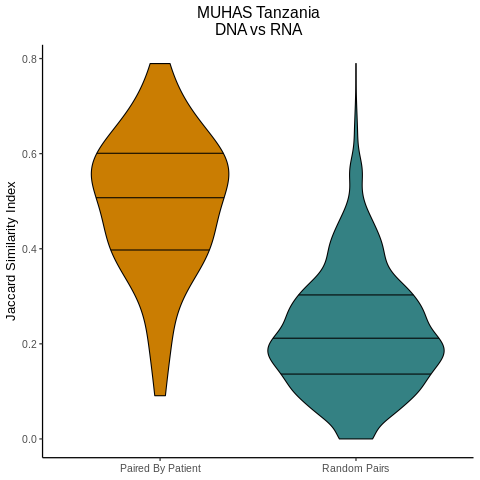

In [26]:
%%R
both_tumor_rna_and_wgs <- colnames(rna)[10:length(rna)][colnames(rna)[10:length(rna)] %in% colnames(wgs_tumor)[10:length(wgs_tumor)]]
rna_4_jaccard <- rna[c(colnames(rna)[1:9], both_tumor_rna_and_wgs)]
wgs_4_jaccard <- wgs_tumor[c(colnames(wgs_tumor)[1:9], both_tumor_rna_and_wgs)]


# Get bacterial genera, and then turn into relative abundance                           
rna_4_jaccard_genera <- extract_data(rna_4_jaccard, 'Bacteria', 'genus', info_cols)
wgs_4_jaccard_genera <- extract_data(wgs_4_jaccard, 'Bacteria', 'genus', info_cols)

rna_4_jaccard_genera <- relative_abundance(rna_4_jaccard_genera)
wgs_4_jaccard_genera <- relative_abundance(wgs_4_jaccard_genera)


# First calculate jaccard distance paired by sample
#------------------------------------------------------------#
jaccard_by_sample <- tibble(sample_name = character(), jaccard_distance = numeric())
colnames(jaccard_by_sample) <- c("sample_name", "jaccard_distance")

# Loop and add information to that table
for (sample_name in both_tumor_rna_and_wgs) {
  jaccard_distance <- get_jaccard(rna_4_jaccard_genera, wgs_4_jaccard_genera, sample_name, threshold=0.01)
  jaccard_by_sample <- add_row(jaccard_by_sample, sample_name = sample_name, jaccard_distance = jaccard_distance)
}

# Now jaccard for all sample_sample pairs...
#------------------------------------------------------------#

get_jaccard_2sample <- function(tbl_1, tbl_2, sample_name1, sample_name2, threshold=0.01) {
  # This function find the jaccard index between a given, common
  # sample_name in two tables. The threshold is a numeric value 
  # n, where only taxa with abundance greater than n are counted.
  
  # Get the column with the name and counts
  tbl1_sample_col <- tbl_1 %>% select(name, sample_name1)
  tbl2_sample_col <- tbl_2 %>% select(name, sample_name2)
  
  # get names of taxa with non-zero counts
  tbl_1_names <- tbl1_sample_col[tbl1_sample_col[2] > threshold,]$name
  tbl_2_names <- tbl2_sample_col[tbl2_sample_col[2] > threshold,]$name
  
  # Get shared names
  shared_names <- intersect(tbl_1_names, tbl_2_names)
  
  # Find total names in either
  total_names <- c(tbl_1_names, tbl_2_names)
  total_names <- total_names[!duplicated(total_names)]
  
  # Divide shared over total - resultant value is jaccard index
  jaccard_index <- length(shared_names)/length(total_names)
  jaccard_index
}


jaccard_random_pairs <- tibble(sample_name = character(), jaccard_distance = numeric())
colnames(jaccard_random_pairs) <- c("sample_name", "jaccard_distance")

# Loop and add information to that table
for (sample_name1 in both_tumor_rna_and_wgs) {
  for (sample_name2 in both_tumor_rna_and_wgs) {
    jaccard_distance <- get_jaccard_2sample(rna_4_jaccard_genera, wgs_4_jaccard_genera, sample_name1, sample_name2, threshold=0.01)
    jaccard_random_pairs <- add_row(jaccard_random_pairs, sample_name = sample_name, jaccard_distance = jaccard_distance)
  }
}


# Combine the jaccards
jaccard_combined <- rbind(
  jaccard_by_sample %>% mutate(Pairing = "Paired By Patient"),
  jaccard_random_pairs %>% mutate(Pairing = "Random Pairs")
)


jaccard_combined_plt <- jaccard_combined %>%
  ggplot() +
  geom_violin(
    aes(x=Pairing, y=jaccard_distance, fill=Pairing),
    color="black",
    draw_quantiles = c(0.25, 0.5, 0.75)
  ) +
  scale_fill_manual(values=c("#CA7D02", "#348183")) +
  theme_classic(base_size=13) +
  ylab("Jaccard Similarity Index") +
  theme(legend.position = "None",
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5)) +
  ggtitle("MUHAS Tanzania\nDNA vs RNA")
jaccard_combined_plt

## PANEL B: Ordered Fuso+friends stacked barcharts of MDEC WGS/RNAseq

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(specified_sample_order)` instead of `specified_sample_order` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


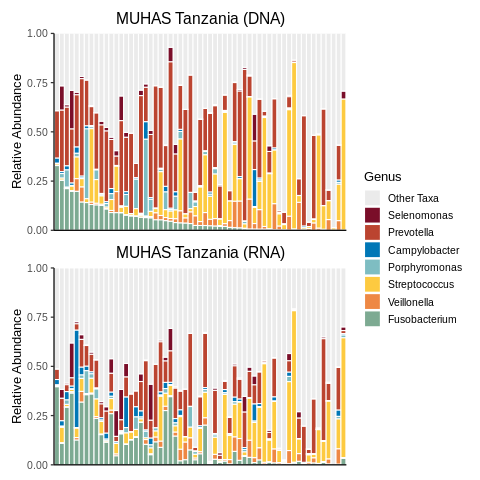

In [27]:
%%R
# Specific for original Tz cohort, plot only samples with both RNA and DNA data and specify order.
genera_of_interest <- c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus","Veillonella", "Fusobacterium")

# Find shared samples
wgs_rna_shared <- colnames(wgs_tumor)[colnames(wgs_tumor) %in% colnames(rna)]


# Plot
tz_wgs_plt <-
  bacteral_taxa_barchart(wgs_tumor %>% select(all_of(wgs_rna_shared)),
                       sort_by_taxon="Fusobacterium",
                       taxa_of_interest= c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus", "Veillonella", "Fusobacterium"),
                       specified_sample_order=FALSE,
                       unneeded_cols = c("tax_id", "taxonomy", "type", "kingdom", "reference_length", "mean", "median", "max"),
                       color_codes = c("#ebebeb", "#7A0E29", "#BB4430", "#0077b6", "#7EBDC2", "#FDCA40", "#EE8844", "#7DAA92") # grey on left..
    )  + ggtitle("MUHAS Tanzania (DNA)")
tz_wgs_plt

# Get the order of the WGS samples by fuso relative abundance
tz_WGS_fuso_order <- tz_wgs_plt$data  %>%
  arrange(order) %>%
  select(Sample) %>%
  pull(Sample)

tz_rna_plt <- bacteral_taxa_barchart(rna,
                       sort_by_taxon="Fusobacterium",
                       taxa_of_interest= c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus", "Veillonella", "Fusobacterium"),
                       specified_sample_order=tz_WGS_fuso_order,
                       unneeded_cols = c("tax_id", "taxonomy", "type", "kingdom", "reference_length", "mean", "median", "max"),
                       color_codes = c("#ebebeb", "#7A0E29", "#BB4430", "#0077b6", "#7EBDC2", "#FDCA40", "#EE8844", "#7DAA92") # grey on left..
  ) + ggtitle("MUHAS Tanzania (RNA)")
 tz_rna_plt


MDEC_fuso_barchart <- tz_wgs_plt/tz_rna_plt + plot_layout(guides = 'collect')
MDEC_fuso_barchart

## PANEL C: barplots of the other cohorts, faceted.

In [28]:
%%R
# Panel C - functions
subset_by_cohort <- function(in_tbl, max_n) {
  # in_tbl - melted, has a column called 'cohort'
  # max_n - if number of samples in a cohort is greater than max_n, max_n will be randomly selected
  # This function will first ID those cohorts with < max_n samples and will extract all of them. Then,
  # it will subset from the remaining. 
  
  set.seed(1)

  # ID cohorts that have <max_n samples... collect their names, and pull them
  # all out from the input tbl
  low_cohorts <- in_tbl %>%
    select(Sample, cohort) %>%
    distinct() %>%
    group_by(cohort) %>%
    tally() %>%
    filter(n < max_n) %>%
    pull(cohort) %>%
    as.character()
  
  
  # Subset only the cohorts that are greater than max_n
  sample_subset <- in_tbl %>%
    filter(!cohort %in% low_cohorts) %>%
    select(Sample, cohort) %>%
    distinct() %>%
    group_by(cohort) %>%
    sample_n(max_n) %>%
    pull(Sample) %>%
    as.character() 
  
  # Add ALL samples from cohorts less than max_n
  additional_samples <- in_tbl %>%
    filter(cohort %in% low_cohorts) %>%
    pull(Sample) %>%
    unique() %>%
    as.character()
  
  sample_subset <- c(sample_subset, additional_samples)
  
  # Return the filtered in_tbl
  in_tbl %>%
    filter(Sample %in% sample_subset)
}

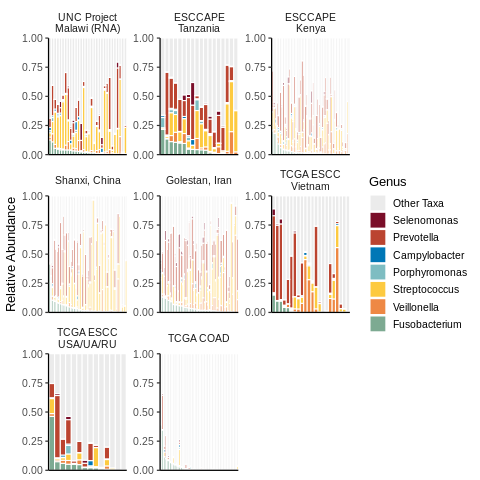

In [29]:
%%R
# Panel C - work
tmp_plt <- bacteral_taxa_barchart(raw_agg,
                       sort_by_taxon="Fusobacterium",
                       taxa_of_interest= c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus", "Veillonella", "Fusobacterium"),
                       specified_sample_order=FALSE,
                       unneeded_cols = c("tax_id", "taxonomy", "type", "kingdom", "reference_length", "mean", "median", "max"),
                       color_codes = c("#ebebeb", "#7A0E29", "#BB4430", "#0077b6", "#7EBDC2", "#FDCA40", "#EE8844", "#7DAA92") # grey on left..

  )

taxa_of_interest <- c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus", "Veillonella", "Fusobacterium")
color_codes <- c("#ebebeb", "#7A0E29", "#BB4430", "#0077b6", "#7EBDC2", "#FDCA40", "#EE8844", "#7DAA92") # grey on left..

data <- tmp_plt$data %>%
  mutate(cohort=hash_lookup(cohort_hashmap, Sample)) %>%
  mutate(Genera=factor(Genera, ordered=T, levels=c("Other Taxa", taxa_of_interest)))

# Remove the MDEC cohorts because they were plotted above
data <- data %>%
  filter(cohort != "MUHAS Tanzania", cohort != "MUHAS Tanzania (RNA)")

# For this plot, lets separate out TCGA
levels_for_agg_barplots <- c("TCGA COAD", "TCGA ESCC\nUSA/UA/RU", "TCGA ESCC\nVietnam", "Golestan, Iran", "Shanxi, China", "ESCCAPE\nKenya", "ESCCAPE\nTanzania", "MUHAS\nTanzania", "MUHAS\nTanzania (RNA)", "UNC Project\nMalawi (RNA)")

data <- data %>%
  mutate(cohort = ifelse(cohort %in% c("TCGA Russia", "TCGA Ukraine", "TCGA USA"), "TCGA ESCC\nUSA/UA/RU", cohort)) %>%
  mutate(cohort = ifelse(cohort %in% c("TCGA Vietnam"), "TCGA ESCC\nVietnam", cohort)) %>%
  mutate(cohort = ifelse(cohort %in% c("UNC Project - Malawi (RNA)"), "UNC Project\nMalawi (RNA)", cohort)) %>%
  mutate(cohort = ifelse(cohort %in% c("MUHAS Tanzania"), "MUHAS\nTanzania", cohort)) %>%
  mutate(cohort = ifelse(cohort %in% c("MUHAS Tanzania (RNA)"), "MUHAS\nTanzania (RNA)", cohort)) %>%
  mutate(cohort = ifelse(cohort %in% c("ESCCAPE Kenya"), "ESCCAPE\nKenya", cohort)) %>%
  mutate(cohort = ifelse(cohort %in% c("ESCCAPE Tanzania"), "ESCCAPE\nTanzania", cohort)) %>%
  mutate(cohort = factor(cohort, ordered=T, levels=rev(levels_for_agg_barplots)))



data <- subset_by_cohort(data, 50)

agg_barplots <- data %>%
  ggplot(
         aes(x=reorder(Sample, order),
             y=rel_abundance,
             fill=Genera
         )
  ) +
    geom_col(stat='identity',
             color="white",
             width=1) + #color=white sets line between bars
    theme_classic(base_size = 13) + # Sets theme, and makes all text 22pt
    theme(axis.title.x=element_blank(), # These element_blank()s remove x axis labels
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          plot.title = element_text(hjust = 0.5),
          strip.background = element_blank()
    ) +
    labs(fill = "Genus") + #rename the legend title
    ylab("Relative Abundance") + #rename y axis title
    scale_y_continuous(expand = c(0, 0)) + #Removes the white space bewteen graph and the bottom black line
    scale_fill_manual(values = color_codes) +
  facet_wrap(~cohort, scales="free")
agg_barplots

## Assmble plots
Note - assembled plots don't render well on google collab

In [ ]:
%%R
assembled <- ((MDEC_fuso_barchart/jaccard_combined_plt + plot_layout(guides = 'auto')) | agg_barplots) + plot_layout(guides = 'collect', widths = c(.5, 1)) + plot_annotation(tag_levels = "A", title="Figure 2")

## Supplementary

R[write to console]: Using name as id variables



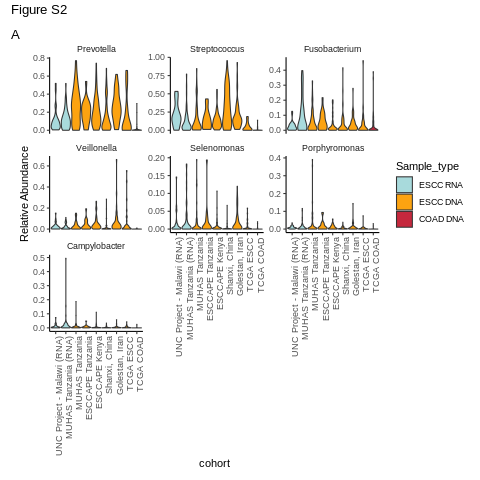

In [31]:
%%R 
# Figure 2S - violins of bacterial genera of all samples
genera_of_interest <- c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus","Veillonella", "Fusobacterium")

agg_bact_genera <- raw_agg %>%
  extract_data("Bacteria", "genus", info_cols) %>%
  relative_abundance()

agg_bact_genera_cohort <- agg_bact_genera %>%
  filter(name %in% genera_of_interest) %>%
  isolate_taxa(genera_of_interest) %>%
  melt() %>%
  mutate(cohort = hash_lookup(cohort_hashmap_TCGAMERGED, variable))

colnames(agg_bact_genera_cohort) <- c("name", "sample", "value", "cohort")

# Order the cohorts
agg_bact_genera_cohort$cohort <- factor(agg_bact_genera_cohort$cohort, ordered=T, levels=rev(cohort_order))

# Label Sample_type
agg_bact_genera_cohort <- agg_bact_genera_cohort %>%
  mutate(Sample_type = ifelse(grepl("RNA", cohort), "ESCC RNA", "ESCC DNA")) %>%
  mutate(Sample_type = ifelse(grepl("COAD", cohort), "COAD DNA", Sample_type))

# Ditch 'other taxa'
agg_bact_genera_cohort <- agg_bact_genera_cohort %>%
  filter(name != "Other Taxa")


# Order the genera by mean
taxa_order <- agg_bact_genera_cohort %>%
  group_by(name) %>%
  summarize(avg = mean(value)) %>%
  arrange(-avg) %>%
  pull(name)

agg_bact_genera_cohort$name <- factor(agg_bact_genera_cohort$name, ordered = T, levels=taxa_order)

cohort_of_interest_vln_plt <- agg_bact_genera_cohort %>%
  ggplot() +
  geom_violin(
    aes(
      x=cohort,
      y=value,
      fill=Sample_type
    ),
    scale="width"
  ) +
  theme_classic(base_size=11) +
  scale_fill_manual(values=c("#C5283D", "#fca311", "#a8dadc")) +
  scale_color_manual(values=c("#C5283D", "#fca311", "#a8dadc")) +
  ylab("Relative Abundance") +
  facet_wrap(~name, scales="free_y") +
  theme(axis.text.x = element_text(angle=90, hjust = 1, size=9),
        strip.background = element_blank()) +
  guides(fill = guide_legend(reverse=T), title="Sample Type") + 
  plot_annotation(tag_levels = "A", title="Figure S2")
cohort_of_interest_vln_plt 